# XMM-LSS master catalogue

This notebook presents the merge of the various pristine catalogues to produce the HELP master catalogue on XMM-LSS.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
33f5ec7 (Wed Dec 6 16:56:17 2017 +0000) [with local modifications]


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import os
import time

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np
from pymoc import MOC

from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
from herschelhelp_internal.utils import coords_to_hpidx, ebv, gen_help_id, inMoc

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
TMP_DIR = os.environ.get('TMP_DIR', "./data_tmp")
OUT_DIR = os.environ.get('OUT_DIR', "./data")
SUFFIX = os.environ.get('SUFFIX', time.strftime("_%Y%m%d"))

try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

## I - Reading the prepared pristine catalogues

In [4]:
#candels = Table.read("{}/CANDELS.fits".format(TMP_DIR))           # 1.1
#cfht_wirds = Table.read("{}/CFHT-WIRDS.fits".format(TMP_DIR))     # 1.3
#cfhtls_wide = Table.read("{}/CFHTLS-WIDE.fits".format(TMP_DIR))   # 1.4a
#cfhtls_deep = Table.read("{}/CFHTLS-DEEP.fits".format(TMP_DIR))   # 1.4b
#We no longer use CFHTLenS as it is the same raw data set as CFHTLS-WIDE
# cfhtlens = Table.read("{}/CFHTLENS.fits".format(TMP_DIR))         # 1.5
#decals = Table.read("{}/DECaLS.fits".format(TMP_DIR))             # 1.6
#servs = Table.read("{}/SERVS.fits".format(TMP_DIR))               # 1.8
#swire = Table.read("{}/SWIRE.fits".format(TMP_DIR))               # 1.7
#hsc_wide = Table.read("{}/HSC-WIDE.fits".format(TMP_DIR))         # 1.9a
#hsc_deep = Table.read("{}/HSC-DEEP.fits".format(TMP_DIR))         # 1.9b
#hsc_udeep = Table.read("{}/HSC-UDEEP.fits".format(TMP_DIR))       # 1.9c
#ps1 = Table.read("{}/PS1.fits".format(TMP_DIR))                   # 1.10
#sxds = Table.read("{}/SXDS.fits".format(TMP_DIR))                 # 1.11
#sparcs = Table.read("{}/SpARCS.fits".format(TMP_DIR))             # 1.12
#dxs = Table.read("{}/UKIDSS-DXS.fits".format(TMP_DIR))            # 1.13
#uds = Table.read("{}/UKIDSS-UDS.fits".format(TMP_DIR))            # 1.14
#vipers = Table.read("{}/VIPERS.fits".format(TMP_DIR))             # 1.15
vhs = Table.read("{}/VISTA-VHS.fits".format(TMP_DIR))             # 1.16
video = Table.read("{}/VISTA-VIDEO.fits".format(TMP_DIR))         # 1.17
viking = Table.read("{}/VISTA-VIKING.fits".format(TMP_DIR))       # 1.18

## II - Merging tables

We first merge the optical catalogues and then add the infrared ones. We start with PanSTARRS because it coevrs the whole field.

At every step, we look at the distribution of the distances to the nearest source in the merged catalogue to determine the best crossmatching radius.

### Start with VHS

In [5]:
master_catalogue = vhs
master_catalogue['vhs_ra'].name = 'ra'
master_catalogue['vhs_dec'].name = 'dec'

### Add VIDEO

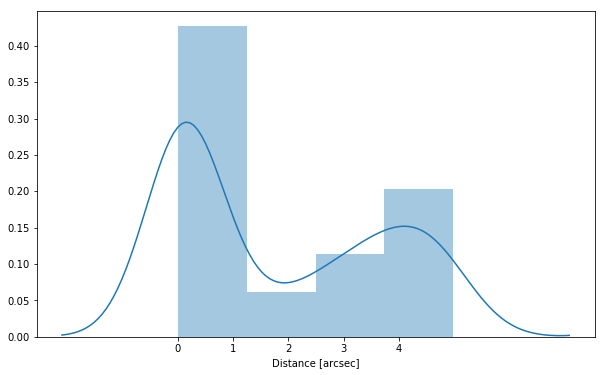

In [6]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(video['video_ra'], video['video_dec'])
)

In [7]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, video, "video_ra", "video_dec", radius=0.8*u.arcsec)

### Add VIKING

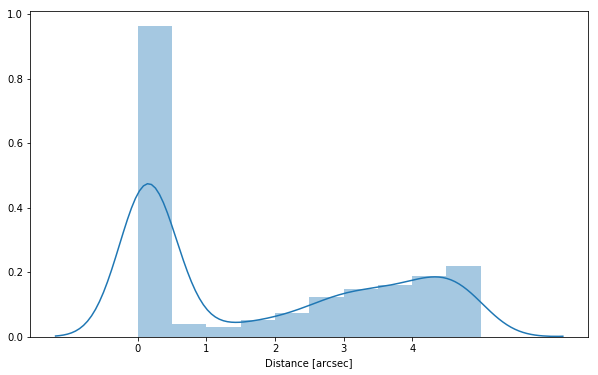

In [8]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(viking['viking_ra'], viking['viking_dec'])
)

In [9]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, viking, "viking_ra", "viking_dec", radius=0.8*u.arcsec)

### Cleaning

When we merge the catalogues, astropy masks the non-existent values (e.g. when a row comes only from a catalogue and has no counterparts in the other, the columns from the latest are masked for that row). We indicate to use NaN for masked values for floats columns, False for flag columns and -1 for ID columns.

In [10]:
for col in master_catalogue.colnames:
    if "m_" in col or "merr_" in col or "f_" in col or "ferr_" in col or "stellarity" in col:
        master_catalogue[col] = master_catalogue[col].astype(float)
        master_catalogue[col].fill_value = np.nan
    elif "flag" in col:
        master_catalogue[col].fill_value = 0
    elif "id" in col:
        master_catalogue[col].fill_value = -1
        
master_catalogue = master_catalogue.filled()

In [11]:
#Since this is not the final merged catalogue. We rename column names to make them unique
master_catalogue['ra'].name = 'vircam_ra'
master_catalogue['dec'].name = 'vircam_dec'
master_catalogue['flag_merged'].name = 'vircam_flag_merged'

In [12]:
master_catalogue[:10].show_in_notebook()

idx,vhs_id,vircam_ra,vircam_dec,vhs_stellarity,m_vhs_y,merr_vhs_y,m_ap_vhs_y,merr_ap_vhs_y,m_vhs_j,merr_vhs_j,m_ap_vhs_j,merr_ap_vhs_j,m_vhs_h,merr_vhs_h,m_ap_vhs_h,merr_ap_vhs_h,m_vhs_k,merr_vhs_k,m_ap_vhs_k,merr_ap_vhs_k,f_vhs_y,ferr_vhs_y,flag_vhs_y,f_ap_vhs_y,ferr_ap_vhs_y,f_vhs_j,ferr_vhs_j,flag_vhs_j,f_ap_vhs_j,ferr_ap_vhs_j,f_vhs_h,ferr_vhs_h,flag_vhs_h,f_ap_vhs_h,ferr_ap_vhs_h,f_vhs_k,ferr_vhs_k,flag_vhs_k,f_ap_vhs_k,ferr_ap_vhs_k,vhs_flag_cleaned,vhs_flag_gaia,vircam_flag_merged,video_id,video_stellarity,m_ap_video_z,merr_ap_video_z,m_video_z,merr_video_z,f_ap_video_z,ferr_ap_video_z,f_video_z,ferr_video_z,m_ap_video_y,merr_ap_video_y,m_video_y,merr_video_y,f_ap_video_y,ferr_ap_video_y,f_video_y,ferr_video_y,m_ap_video_j,merr_ap_video_j,m_video_j,merr_video_j,f_ap_video_j,ferr_ap_video_j,f_video_j,ferr_video_j,m_ap_video_h,merr_ap_video_h,m_video_h,merr_video_h,f_ap_video_h,ferr_ap_video_h,f_video_h,ferr_video_h,m_ap_video_k,merr_ap_video_k,m_video_k,merr_video_k,f_ap_video_k,ferr_ap_video_k,f_video_k,ferr_video_k,flag_video_z,flag_video_y,flag_video_j,flag_video_h,flag_video_k,video_flag_cleaned,video_flag_gaia,viking_id,viking_stellarity,m_viking_z,merr_viking_z,m_ap_viking_z,merr_ap_viking_z,m_viking_y,merr_viking_y,m_ap_viking_y,merr_ap_viking_y,m_viking_j,merr_viking_j,m_ap_viking_j,merr_ap_viking_j,m_viking_h,merr_viking_h,m_ap_viking_h,merr_ap_viking_h,m_viking_k,merr_viking_k,m_ap_viking_k,merr_ap_viking_k,f_viking_z,ferr_viking_z,flag_viking_z,f_ap_viking_z,ferr_ap_viking_z,f_viking_y,ferr_viking_y,flag_viking_y,f_ap_viking_y,ferr_ap_viking_y,f_viking_j,ferr_viking_j,flag_viking_j,f_ap_viking_j,ferr_ap_viking_j,f_viking_h,ferr_viking_h,flag_viking_h,f_ap_viking_h,ferr_ap_viking_h,f_viking_k,ferr_viking_k,flag_viking_k,f_ap_viking_k,ferr_ap_viking_k,viking_flag_cleaned,viking_flag_gaia
,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,472511809653,34.9201754247,-4.345667767,0.0524781383574,nan,nan,nan,nan,9.2613992691,0.000139235809911,13.6462526321,0.00106575945392,10.6136102676,0.000282026128843,12.2605009079,0.000574934645556,9.51158809662,0.000179869588464,15.1603183746,0.0029498480726,nan,nan,False,nan,nan,716869.5625,91.9320068359,False,12632.7773438,12.400343895,206326.859375,53.5945701599,False,45268.8554688,23.971414566,569330.6875,94.3187408447,False,3132.3659668,8.51035881042,False,0,False,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,False,False,False,False,False,0,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,False,0
1,472511816927,34.9198005174,-4.34503351374,0.899999976158,nan,nan,nan,nan,nan,nan,nan,nan,11.1817598343,0.000340650090948,12.2731513977,0.000578326231334,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,122263.234375,38.3601341248,False,44744.4648438,23.8335056305,nan,nan,False,nan,nan,False,0,False,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,False,False,False,False,False,0,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,False,0
2,472511816928,34.919461689,-4.34539258754,0.899999976158,nan,nan,nan,nan,nan,nan,nan,nan,11.8767585754,0.000443481811089,12.3065862656,0.000587735383306,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,64460.9023438,26.3298187256,False,43387.5742188,23.4867477417,nan,nan,False,nan,nan,False,0,False,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,n

In [13]:

master_catalogue.add_column(Column(data=(np.char.array(master_catalogue['vhs_id'].astype(str)) 
                                    +  np.char.array(master_catalogue['video_id'].astype(str) )
                                    +  np.char.array(master_catalogue['viking_id'].astype(str))), 
                              name="vircam_intid"))

In [14]:
id_names = []
for col in master_catalogue.colnames:
    if '_id' in col:
        id_names += [col]
    if '_intid' in col:
        id_names += [col]
        
print(id_names)

['vhs_id', 'video_id', 'viking_id', 'vircam_intid']


## VII - Choosing between multiple values for the same filter



### VII.c VISTA VIDEO, VHS, and VIKING: VISTA fluxes

According to Mattia Vacari VIDEO is deeper than VIKING which is deeper than VHS

In [15]:
vista_origin = Table()
vista_origin.add_column(master_catalogue['vircam_intid'])

In [16]:
vista_stats = Table()
vista_stats.add_column(Column(data=['y','j','h','k','z'], name="Band"))
vista_stats.add_column(Column(data=np.full(5, 0), name="VIDEO"))
vista_stats.add_column(Column(data=np.full(5, 0), name="VIKING"))
vista_stats.add_column(Column(data=np.full(5, 0), name="VHS"))
vista_stats.add_column(Column(data=np.full(5, 0), name="use VIDEO"))
vista_stats.add_column(Column(data=np.full(5, 0), name="use VIKING"))
vista_stats.add_column(Column(data=np.full(5, 0), name="use VHS"))
vista_stats.add_column(Column(data=np.full(5, 0), name="VIDEO ap"))
vista_stats.add_column(Column(data=np.full(5, 0), name="VIKING ap"))
vista_stats.add_column(Column(data=np.full(5, 0), name="VHS ap"))
vista_stats.add_column(Column(data=np.full(5, 0), name="use VIDEO ap"))
vista_stats.add_column(Column(data=np.full(5, 0), name="use VIKING ap"))
vista_stats.add_column(Column(data=np.full(5, 0), name="use VHS ap"))

In [17]:

vista_bands = ['y','j','h','k','z'] # Lowercase naming convention (k is Ks)
for band in vista_bands:
    #print('For VISTA band ' + band + ':')
    # VISTA total flux 
    has_video = ~np.isnan(master_catalogue['f_video_' + band])
    has_viking = ~np.isnan(master_catalogue['f_viking_' + band])
    if band == 'z':
        has_vhs = np.full(len(master_catalogue), False)
    else:
        has_vhs = ~np.isnan(master_catalogue['f_vhs_' + band])
    

    #print("{} sources with VIDEO flux".format(np.sum(has_video)))
    #print("{} sources with VIKING flux".format(np.sum(has_viking)))
    #print("{} sources with VHS flux".format(np.sum(has_vhs)))
    #print("{} sources with VIDEO, VIKING, and VHS flux".format(np.sum(has_video & has_viking & has_vhs)))


    use_video = has_video 
    use_viking = has_viking & ~has_video
    use_vhs = has_vhs & ~has_video & ~has_viking

    #print("{} sources for which we use VIDEO".format(np.sum(use_video)))
    #print("{} sources for which we use VIKING".format(np.sum(use_viking)))
    #print("{} sources for which we use VHS".format(np.sum(use_vhs)))

    f_vista = np.full(len(master_catalogue), np.nan)
    f_vista[use_video] = master_catalogue['f_video_' + band][use_video]
    f_vista[use_viking] = master_catalogue['f_viking_' + band][use_viking]
    if not (band == 'z'):
        f_vista[use_vhs] = master_catalogue['f_vhs_' + band][use_vhs]

    ferr_vista = np.full(len(master_catalogue), np.nan)
    ferr_vista[use_video] = master_catalogue['ferr_video_' + band][use_video]
    ferr_vista[use_viking] = master_catalogue['ferr_viking_' + band][use_viking]
    if not (band == 'z'):
        ferr_vista[use_vhs] = master_catalogue['ferr_vhs_' + band][use_vhs]
    
    m_vista = np.full(len(master_catalogue), np.nan)
    m_vista[use_video] = master_catalogue['m_video_' + band][use_video]
    m_vista[use_viking] = master_catalogue['m_viking_' + band][use_viking]
    if not (band == 'z'):
        m_vista[use_vhs] = master_catalogue['m_vhs_' + band][use_vhs]

    merr_vista = np.full(len(master_catalogue), np.nan)
    merr_vista[use_video] = master_catalogue['merr_video_' + band][use_video]
    merr_vista[use_viking] = master_catalogue['merr_viking_' + band][use_viking]
    if not (band == 'z'):
        merr_vista[use_vhs] = master_catalogue['merr_vhs_' + band][use_vhs]

    flag_vista = np.full(len(master_catalogue), False, dtype=bool)
    flag_vista[use_video] = master_catalogue['flag_video_' + band][use_video]
    flag_vista[use_viking] = master_catalogue['flag_viking_' + band][use_viking]
    if not (band == 'z'):
        flag_vista[use_vhs] = master_catalogue['flag_vhs_' + band][use_vhs]

    master_catalogue.add_column(Column(data=f_vista, name="f_vista_" + band))
    master_catalogue.add_column(Column(data=ferr_vista, name="ferr_vista_" + band))
    master_catalogue.add_column(Column(data=m_vista, name="m_vista_" + band))
    master_catalogue.add_column(Column(data=merr_vista, name="merr_vista_" + band))
    master_catalogue.add_column(Column(data=flag_vista, name="flag_vista_" + band))

    old_video_and_viking_columns = ['f_video_' + band, 
                                     'f_viking_' + band, 
                                     'ferr_video_' + band,
                                     'ferr_viking_' + band, 
                                     'm_video_' + band, 
                                     'm_viking_' + band, 
                                     'merr_video_' + band,
                                     'merr_viking_' + band,
                                     'flag_video_' + band, 
                                     'flag_viking_' + band]
    old_vhs_columns = ['f_vhs_' + band, 
                       'ferr_vhs_' + band, 
                       'm_vhs_' + band, 
                       'merr_vhs_' + band,
                       'flag_vhs_' + band]
    
    if not (band == 'z'):
        old_columns = old_video_and_viking_columns + old_vhs_columns
    else:
        old_columns = old_video_and_viking_columns
    master_catalogue.remove_columns(old_columns)

    origin = np.full(len(master_catalogue), '     ', dtype='<U5')
    origin[use_video] = "VIDEO"
    origin[use_viking] = "VIKING"
    origin[use_vhs] = "VHS"
    
    vista_origin.add_column(Column(data=origin, name= 'f_vista_' + band ))
    
    
    
    # VISTA Aperture flux
    has_ap_video = ~np.isnan(master_catalogue['f_ap_video_' + band])
    has_ap_viking = ~np.isnan(master_catalogue['f_ap_viking_' + band])
    if (band == 'z'):
        has_ap_vhs = np.full(len(master_catalogue), False)
    else:
        has_ap_vhs = ~np.isnan(master_catalogue['f_ap_vhs_' + band])

    #print("{} sources with VIDEO aperture flux".format(np.sum(has_ap_video)))
    #print("{} sources with VIKING aperture flux".format(np.sum(has_ap_viking)))
    #print("{} sources with VHS aperture flux".format(np.sum(has_ap_vhs)))
    #print("{} sources with VIDEO, VIKING and VHS aperture flux".format(np.sum(has_ap_video & has_ap_viking & has_ap_vhs)))

    use_ap_video = has_ap_video 
    use_ap_viking = has_ap_viking & ~has_ap_video
    use_ap_vhs = has_ap_vhs & ~has_ap_video & ~has_ap_viking

    #print("{} sources for which we use VIDEO aperture fluxes".format(np.sum(use_ap_video)))
    #print("{} sources for which we use VIKING aperture fluxes".format(np.sum(use_ap_viking)))
    #print("{} sources for which we use VHS aperture fluxes".format(np.sum(use_ap_vhs)))

    f_ap_vista = np.full(len(master_catalogue), np.nan)
    f_ap_vista[use_ap_video] = master_catalogue['f_ap_video_' + band][use_ap_video]
    f_ap_vista[use_ap_viking] = master_catalogue['f_ap_viking_' + band][use_ap_viking]
    if not (band == 'z'):
        f_ap_vista[use_ap_vhs] = master_catalogue['f_ap_vhs_' + band][use_ap_vhs]

    ferr_ap_vista = np.full(len(master_catalogue), np.nan)
    ferr_ap_vista[use_ap_video] = master_catalogue['ferr_ap_video_' + band][use_ap_video]
    ferr_ap_vista[use_ap_viking] = master_catalogue['ferr_ap_viking_' + band][use_ap_viking]
    if not (band == 'z'):
        ferr_ap_vista[use_ap_vhs] = master_catalogue['ferr_ap_vhs_' + band][use_ap_vhs]
    
    m_ap_vista = np.full(len(master_catalogue), np.nan)
    m_ap_vista[use_ap_video] = master_catalogue['m_ap_video_' + band][use_ap_video]
    m_ap_vista[use_ap_viking] = master_catalogue['m_ap_viking_' + band][use_ap_viking]
    if not (band == 'z'):
        m_ap_vista[use_ap_vhs] = master_catalogue['m_ap_vhs_' + band][use_ap_vhs]

    merr_ap_vista = np.full(len(master_catalogue), np.nan)
    merr_ap_vista[use_ap_video] = master_catalogue['merr_ap_video_' + band][use_ap_video]
    merr_ap_vista[use_ap_viking] = master_catalogue['merr_ap_viking_' + band][use_ap_viking]
    if not (band == 'z'):
        merr_ap_vista[use_ap_vhs] = master_catalogue['merr_ap_vhs_' + band][use_ap_vhs]


    master_catalogue.add_column(Column(data=f_ap_vista, name="f_ap_vista_" + band))
    master_catalogue.add_column(Column(data=ferr_ap_vista, name="ferr_ap_vista_" + band))
    master_catalogue.add_column(Column(data=m_ap_vista, name="m_ap_vista_" + band))
    master_catalogue.add_column(Column(data=merr_vista, name="merr_ap_vista_" + band))


    ap_old_video_and_viking_columns = ['f_ap_video_' + band, 
                                     'f_ap_viking_' + band, 
                                     'ferr_ap_video_' + band,
                                     'ferr_ap_viking_' + band, 
                                     'm_ap_video_' + band, 
                                     'm_ap_viking_' + band, 
                                     'merr_ap_video_' + band,
                                     'merr_ap_viking_' + band]
    ap_old_vhs_columns = ['f_ap_vhs_' + band, 
                       'ferr_ap_vhs_' + band, 
                       'm_ap_vhs_' + band, 
                       'merr_ap_vhs_' + band]
    
    if not (band == 'z'):
        ap_old_columns = ap_old_video_and_viking_columns + ap_old_vhs_columns
    else:
        ap_old_columns = ap_old_video_and_viking_columns
    master_catalogue.remove_columns(ap_old_columns)

    origin_ap = np.full(len(master_catalogue), '     ', dtype='<U5')
    origin_ap[use_ap_video] = "VIDEO"
    origin_ap[use_ap_viking] = "VIKING"
    origin_ap[use_ap_vhs] = "VHS"
    
    vista_origin.add_column(Column(data=origin_ap, name= 'f_ap_vista_' + band ))
    
    vista_stats['VIDEO'][vista_stats['Band'] == band] = np.sum(has_video)
    vista_stats['VIKING'][vista_stats['Band'] == band] = np.sum(has_viking)
    vista_stats['VHS'][vista_stats['Band'] == band] = np.sum(has_vhs)
    vista_stats['use VIDEO'][vista_stats['Band'] == band] = np.sum(use_video)
    vista_stats['use VIKING'][vista_stats['Band'] == band] = np.sum(use_viking)
    vista_stats['use VHS'][vista_stats['Band'] == band] = np.sum(use_vhs)
    vista_stats['VIDEO ap'][vista_stats['Band'] == band] = np.sum(has_ap_video)
    vista_stats['VIKING ap'][vista_stats['Band'] == band] = np.sum(has_ap_viking)
    vista_stats['VHS ap'][vista_stats['Band'] == band] = np.sum(has_ap_vhs)
    vista_stats['use VIDEO ap'][vista_stats['Band'] == band] = np.sum(use_ap_video)
    vista_stats['use VIKING ap'][vista_stats['Band'] == band] = np.sum(use_ap_viking)
    vista_stats['use VHS ap'][vista_stats['Band'] == band] = np.sum(use_ap_vhs)

In [18]:
for col in master_catalogue.colnames:
    if 'vista' in col:
        master_catalogue[col].name  = col.replace('vista', 'vircam')

### Vista origin overview
For each band show how many objects have fluxes from each survey for both total and aperture photometries.

In [19]:
vista_stats.show_in_notebook()

idx,Band,VIDEO,VIKING,VHS,use VIDEO,use VIKING,use VHS,VIDEO ap,VIKING ap,VHS ap,use VIDEO ap,use VIKING ap,use VHS ap
0,y,6336,1996,0,6336,1983,0,6314,1996,0,6314,1983,0
1,j,6341,3330,7240,6341,2904,6631,6321,3330,7238,6321,2904,6629
2,h,6307,3521,6938,6307,3051,6286,6256,3521,6936,6256,3051,6284
3,k,6228,3816,6261,6228,3238,5649,6126,3816,6261,6126,3238,5649
4,z,1093,3396,0,1093,3393,0,1093,3396,0,1093,3393,0


In [20]:
vista_origin.write("{}/xmm-lss_vista_fluxes_origins{}.fits".format(OUT_DIR, SUFFIX), overwrite=True)

## XI - Saving the catalogue

In [21]:
columns = ["help_id", "field", "ra", "dec", "hp_idx"]

bands = [column[5:] for column in master_catalogue.colnames if 'f_ap' in column]
for band in bands:
    columns += ["f_ap_{}".format(band), "ferr_ap_{}".format(band),
                "m_ap_{}".format(band), "merr_ap_{}".format(band),
                "f_{}".format(band), "ferr_{}".format(band),
                "m_{}".format(band), "merr_{}".format(band),
                "flag_{}".format(band)]    
    
columns += ["stellarity", "stellarity_origin", "flag_cleaned", "flag_merged", "flag_gaia", "flag_optnir_obs", "flag_optnir_det", 
            "zspec", "zspec_qual", "zspec_association_flag", "ebv"]

In [22]:
# We check for columns in the master catalogue that we will not save to disk.
print("Missing columns: {}".format(set(master_catalogue.colnames) - set(columns)))

Missing columns: {'video_flag_cleaned', 'viking_flag_cleaned', 'video_stellarity', 'video_flag_gaia', 'vhs_flag_cleaned', 'video_id', 'vircam_flag_merged', 'vhs_flag_gaia', 'vircam_intid', 'vhs_stellarity', 'vircam_ra', 'vircam_dec', 'vhs_id', 'viking_stellarity', 'viking_flag_gaia', 'viking_id'}


In [23]:
master_catalogue.write("{}/vircam_merged_catalogue_xmm-lss.fits".format(TMP_DIR), overwrite=True)